In [1]:
import numpy as np
import pandas as pd
import random
import cvxopt
from cvxopt import matrix, solvers
from cvxopt.modeling import variable
from tqdm.notebook import tqdm
from sklearn.svm import SVC
from libsvm.svmutil import *
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
random.seed(42)

In [22]:
SUBSET = [False,2000] # if True, 2nd val is # of points 
N_FOLDS = 5 # k-Fold cross validation
NUM_FEATURES = 25 # <=25 for the given data
SPLIT = 0.9 # Test-train split (for individual)
MODE = 'LIBSVM' # 'LIBSVM', 'CVXOPT', 'SSMO'
BINARY_CLASSIFICATION = False # Binary classification/Multiclass
C1,C2 = 1,8 # Classes (0-9)
KERNEL = 'LINEAR' # 'LINEAR', 'POLY', 'RBF'
GAMMA = 0.001 # Gamma for RBF Kernel
C = 3.0 # C for L1 regularization
POWER = 2 # Power in Polynomial kernel
COEFF = 4 # Coefficient in Polynomial kernel
MAX_PASSES = 5 # Number of passes in SSMO
TOLERANCE = 1e-3 # Tolerance for SSMO

In [23]:
def getData():
    df = pd.read_csv('train_set.csv',header=None)
    if BINARY_CLASSIFICATION:
        df = df[(df[25] == C1) | (df[25] == C2)]
    dataset = []
    for i,row in df.iterrows():
        xi = []
        for j in range(0,NUM_FEATURES):
            xi.append(row[j])
        if BINARY_CLASSIFICATION:
            if(row[25]==C1):
                xi.append(-1.0)
            else:
                xi.append(1.0)
        else:
            xi.append(row[25])
        dataset.append(xi)
    
    if SUBSET[0]==True:
        dataset = dataset[:SUBSET[1]]
    return dataset

In [24]:
def cross_validation_split(dataset):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / N_FOLDS)
    for i in range(N_FOLDS):
        fold = list()
        while len(fold) < fold_size:
            index = random.randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

In [25]:
dataset = getData()

In [26]:
dataset_split = cross_validation_split(dataset)

In [7]:
class SVM:
    def __init__(self,mode='CVXOPT',kernel='LINEAR',C = 3.0,gamma = 0.001, power = 2, coeff = 4, max_passes = 5, tol=1e-3):
        self.mode = mode
        self.kernel = kernel
        self.C = C
        self.gamma = gamma
        self.power = power
        self.coeff = coeff
        self.max_passes = max_passes
        self.tol = tol
    
    def fit(self,X,y):
        X = np.array(X)
        y = np.array(y)
        num_samples,num_features = X.shape
        K = np.zeros((num_samples,num_samples))
        
        for i in (range(num_samples)):
            for j in range(num_samples):
                if self.kernel == 'LINEAR':
                    K[i][j] = np.dot(X[i],np.transpose(X[j]))
                elif self.kernel == 'POLY':
                    K[i][j] = (np.dot(X[i],np.transpose(X[j])) + self.coeff) ** self.power
                elif self.kernel == 'RBF':
                    K[i][j] = np.exp(-1 * self.gamma*np.sum(np.square(X[i]-X[j])))
        
        self.K = K
        
        if self.mode == 'CVXOPT':
            H = np.zeros((num_samples,num_samples))
            for i in (range(num_samples)):
                for j in range(num_samples):
                    H[i][j] = y[i]*y[j] * K[i][j]
            P = matrix(H)
            q = matrix(np.ones(num_samples) * -1)
            G = matrix(np.vstack(((np.identity(num_samples) * -1),np.identity(num_samples))))
            h = matrix(np.hstack((np.zeros(num_samples),np.ones(num_samples)*self.C)))
            A = matrix(y,(1,num_samples))
            b = matrix(0.0)

            solvers.options['show_progress'] = False
            soln = solvers.qp(P,q,G,h,A,b)
            alpha = np.array(soln['x']) 

            self.sup_idx = np.where(alpha>1e-5)[0]
            self.ind =  np.arange(len(alpha))[self.sup_idx]

            self.sup_x = X[self.sup_idx,:]
            self.sup_y = y[self.sup_idx]
            self.alpha = alpha[self.sup_idx]
            self.b = self.sup_y[0]

            for i in range(len(self.alpha)):
                if self.kernel == 'LINEAR':
                    temp = np.dot(self.sup_x[i],np.transpose(self.sup_x[0]))
                elif self.kernel == 'POLY':
                    temp = (np.dot(self.sup_x[i],np.transpose(self.sup_x[0]))+self.coeff)**self.power
                elif self.kernel == 'RBF':
                    temp = np.exp(-1 * self.gamma*np.sum(np.square(self.sup_x[i]-self.sup_x[0])))
                self.b -= self.alpha[i] * self.sup_y[i] * temp
        
        elif self.mode == 'SSMO':
            alpha = np.zeros((num_samples))
            alpha_old = np.zeros((num_samples))
            E = np.zeros((num_samples))
            b = 0
            passes = 0
            while(passes<self.max_passes):
                num_changed_alpha = 0
                for i in range(num_samples):
                    E[i] = np.sum(alpha * y * self.K[:,i]) + b - y[i]

                    if (y[i] * E[i] < -self.tol and alpha[i]<self.C) or (y[i] * E[i] > self.tol and alpha[i]>0):
                        j = random.randint(0,num_samples-1)
                        while j == i:
                            j = random.randint(0,num_samples-1)

                        E[j] = np.sum(alpha * y * self.K[:,j]) + b - y[j]
                        alpha_old[i] = alpha[i]
                        alpha_old[j] = alpha[j]

                        if y[i] != y[j]:
                            L = max(0,alpha[j] - alpha[i])
                            H = min(self.C,self.C+alpha[j] - alpha[i])
                        else:
                            L = max(0,alpha[i]+alpha[j] - self.C)
                            H = min(self.C,alpha[i] + alpha[j])

                        if L==H:
                            continue

                        eta = 2* self.K[i][j] - self.K[i][i] - self.K[j][j]

                        if eta>=0:
                            continue

                        alpha[j] = alpha[j] - y[j] * (E[i] - E[j])/eta

                        if alpha[j]>H:
                            alpha[j] = H
                        elif alpha[j]<L:
                            alpha[j] = L

                        if abs(alpha[j] - alpha_old[j]) < 1e-5:
                            continue

                        alpha[i] = alpha[i] + y[i]* y[j] * (alpha_old[j] - alpha[j])

                        b1 = b - E[i] - y[i] * (alpha[i] - alpha_old[i]) * self.K[i][i] \
                            - y[j] * (alpha[j] - alpha_old[j]) * self.K[i][j]
                        b2 = b - E[j] - y[i] * (alpha[i] - alpha_old[i]) * self.K[i][j] \
                            - y[j] * (alpha[j] - alpha_old[j]) * self.K[j][j] 

                        if 0<alpha[i] and alpha[i] <self.C:
                            b = b1
                        elif 0<alpha[j] and alpha[j] < self.C:
                            b = b2
                        else:
                            b = (b1+b2)/2

                        num_changed_alpha +=1

                if num_changed_alpha == 0:
                    passes+=1
                else:
                    passes=0

            self.b = b
            self.sup_idx = np.where(alpha>0)[0]
            self.sup_x = X[self.sup_idx,:]
            self.sup_y = y[self.sup_idx]
            self.alpha = alpha[self.sup_idx]
            self.w = np.dot(alpha*y,X).T
        
    def predict(self,X):
        preds = []
        for x in X:
            pred = 0
            for i in range(len(self.alpha)):
                if self.kernel == 'LINEAR':
                    temp = np.dot(self.sup_x[i],np.transpose(x))
                elif self.kernel == 'POLY':
                    temp = (np.dot(self.sup_x[i],np.transpose(x)) + self.coeff) ** self.power
                elif self.kernel == 'RBF':
                    temp = np.exp(-1 * self.gamma *np.sum(np.square(self.sup_x[i]-x)))
                pred += self.alpha[i] * self.sup_y[i] * temp
            pred += self.b
            if pred>=0:
                preds.append(1.0)
            else:
                preds.append(-1.0)
        return np.array(preds)

In [8]:
def getAccuracy(preds,testY):
    correct = 0
    for i in range(len(testY)):
        if preds[i] == testY[i]:
            correct +=1
    return correct/len(testY) * 100

In [9]:
def evaluateCrossEval(dataset_split):
    train_acc_list = []
    test_acc_list = []
    for fold in (dataset_split):
        trainDS = list(dataset_split)
        trainDS.remove(fold)
        trainDS = sum(trainDS,[])
        testDS = list()
        
        for row in fold:
            rowCopy = list(row)
            testDS.append(rowCopy)
        
        trainX = [train[:-1] for train in trainDS]
        trainY = [train[-1] for train in trainDS]
        
        testX = [test[:-1] for test in testDS]
        testY = [test[-1] for test in testDS]
        
        if BINARY_CLASSIFICATION == False or MODE == 'LIBSVM':
            prob = svm_problem(trainY,trainX)
            param = svm_parameter()
            kernel_string_map = {
                'LINEAR': LINEAR,
                'POLY': POLY,
                'RBF': RBF
            }
            param.kernel_type = kernel_string_map[KERNEL]
            param.C = C
            param.gamma = GAMMA
            param.degree = POWER
            param.coef0 = COEFF
            m = svm_train(prob,param,'-q')
            t_label, t_acc, t_val = svm_predict(trainY, trainX, m,'-q')
            p_label, p_acc, p_val = svm_predict(testY, testX, m,'-q')
            train_acc_list.append(t_acc[0])
            test_acc_list.append(p_acc[0])
        else:
            cf = SVM(mode=MODE,kernel=KERNEL,gamma=GAMMA,C=C,power=POWER,coeff=COEFF,max_passes=MAX_PASSES,tol=TOLERANCE)
            cf.fit(trainX,trainY)
            
            train_preds = cf.predict(trainX)
            test_preds = cf.predict(testX)
            
            train_acc = getAccuracy(train_preds,trainY)
            test_acc = getAccuracy(test_preds,testY)
            test_acc_list.append(test_acc)
        
    return np.mean(train_acc_list),np.mean(test_acc_list)

In [10]:
evaluateCrossEval(dataset_split)

(97.2875, 86.8)

In [11]:
# for MODE in ['LIBSVM', 'CVXOPT', 'SSMO']:
#     starttime = datetime.now()
#     _,acc = evaluate(dataset_split)
#     endtime = datetime.now()
#     duration = (endtime-starttime)
#     duration = duration
#     print(MODE,acc,duration)

In [12]:
def evaluateSplit(dataset):
    n = len(dataset)
    trainDS = dataset[:int(SPLIT*n)]
    testDS = dataset[int(SPLIT*n):]
    
    trainX = [train[:-1] for train in trainDS]
    trainY = [train[-1] for train in trainDS]

    testX = [test[:-1] for test in testDS]
    testY = [test[-1] for test in testDS]
    
    if BINARY_CLASSIFICATION == False or MODE == 'LIBSVM':
        prob = svm_problem(trainY,trainX)
        param = svm_parameter()
        kernel_string_map = {
            'LINEAR': LINEAR,
            'POLY': POLY,
            'RBF': RBF
        }
        param.kernel_type = kernel_string_map[KERNEL]
        param.C = C
        param.gamma = GAMMA
        param.degree = POWER
        param.coef0 = COEFF
        m = svm_train(prob,param,'-q')
        t_label, t_acc, t_val = svm_predict(trainY, trainX, m,'-q')
        p_label, p_acc, p_val = svm_predict(testY, testX, m,'-q')
        return _,t_acc[0],p_acc[0]
    else:
        cf = SVM(mode=MODE,kernel=KERNEL,gamma=GAMMA,C=C,power=POWER,coeff=COEFF,max_passes=MAX_PASSES,tol=TOLERANCE)
        cf.fit(trainX,trainY)

        train_preds = cf.predict(trainX)
        test_preds = cf.predict(testX)

        train_acc = getAccuracy(train_preds,trainY)
        test_acc = getAccuracy(test_preds,testY)
        return cf.sup_idx,train_acc,test_acc
    

In [13]:
KERNEL = "LINEAR"
MODE = "LIBSVM"

In [14]:
train_acc_list = []
test_acc_list = []
for C in [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

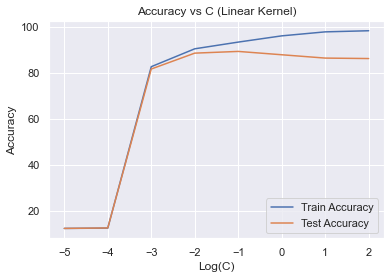

In [15]:
X = [-5,-4,-3,-2,-1,0,1,2]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(C)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C (Linear Kernel)')
plt.legend()
#plt.savefig('Plots/Accuracy vs C (Linear Kernel).png',dpi=1200)
plt.show()


In [16]:
KERNEL = "RBF"

In [17]:
train_acc_list = []
test_acc_list = []
#GAMMA = 0.03
GAMMA = 1/(NUM_FEATURES)
for C in [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(C,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-05 12.45 12.45
0.0001 12.45 12.45
0.001 12.45 12.45
0.01 14.05 13.3
0.1 91.8375 89.15
1.0 99.025 94.3
10.0 100.0 94.65
100.0 100.0 94.65


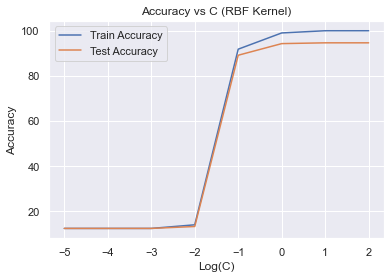

In [18]:
X = [-5,-4,-3,-2,-1,0,1,2]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(C)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C (RBF Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs C (RBF Kernel).png',dpi=1200)
plt.show()

In [19]:
train_acc_list = []
test_acc_list = []
C = 1
for GAMMA in [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(GAMMA,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-05 12.45 12.45
0.0001 36.025 33.9
0.001 87.3 86.15
0.01 94.675 92.65
0.1 99.875 94.0
1.0 100.0 20.7
10.0 100.0 12.45


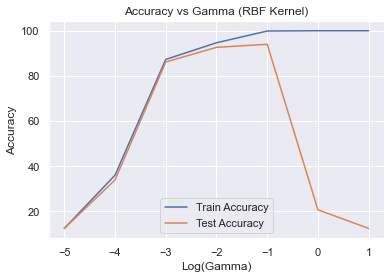

In [20]:
X = [-5,-4,-3,-2,-1,0,1]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(Gamma)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Gamma (RBF Kernel)')
plt.legend()
#plt.savefig('Plots/Accuracy vs Gamma (RBF Kernel).png',dpi=1200)
plt.show()

In [28]:
KERNEL = "RBF"
C = 1
GAMMA = 1/NUM_FEATURES

In [29]:
train_acc,test_acc = evaluateCrossEval(dataset_split)
print(GAMMA,train_acc,test_acc)

0.04 99.021875 96.6625


In [30]:
KERNEL = "RBF"
C = 1
GAMMA = 0.02

In [31]:
train_acc,test_acc = evaluateCrossEval(dataset_split)
print(GAMMA,train_acc,test_acc)

0.02 97.709375 95.8


In [32]:
KERNEL = "RBF"
C = 1
GAMMA = 0.05

In [33]:
train_acc,test_acc = evaluateCrossEval(dataset_split)
print(GAMMA,train_acc,test_acc)

0.05 99.33125 96.7875


In [34]:
KERNEL = "RBF"
C = 10
GAMMA = 1/NUM_FEATURES

In [35]:
train_acc,test_acc = evaluateCrossEval(dataset_split)
print(GAMMA,train_acc,test_acc)

0.04 100.0 97.0


In [40]:
def getTestData():
    df = pd.read_csv('test_set.csv',header=None)
    if BINARY_CLASSIFICATION:
        df = df[(df[25] == C1) | (df[25] == C2)]
    dataset = []
    for i,row in df.iterrows():
        xi = []
        for j in range(0,NUM_FEATURES):
            xi.append(row[j])
        dataset.append(xi)
    return dataset

In [41]:
testData = getTestData()

In [43]:
np.array(testData).shape

(2000, 25)

In [46]:
KERNEL = "RBF"
C = 1
GAMMA = 0.05

In [45]:
trainDS = dataset
trainX = [train[:-1] for train in trainDS]
trainY = [train[-1] for train in trainDS]

In [48]:
prob = svm_problem(trainY,trainX)
param = svm_parameter()
kernel_string_map = {
    'LINEAR': LINEAR,
    'POLY': POLY,
    'RBF': RBF
}
param.kernel_type = kernel_string_map[KERNEL]
param.C = C
param.gamma = GAMMA
param.degree = POWER
param.coef0 = COEFF
m = svm_train(prob,param,'-q')
t_label, t_acc, t_val = svm_predict(trainY, trainX, m,'-q')
p_label, p_acc, p_val = svm_predict([], testData, m,'-q')

In [50]:
len(p_label)

2000

In [53]:
Y_pred = np.array(p_label)
with open('foo.csv', 'w+') as f:
  f.write('Id,Class\n')
  for i in range(Y_pred.shape[0]):
    if i + 1 < 1000: 
      f.write('{},{:d}\n'.format(str(i+1), int(Y_pred[i])))
    else:
      f.write('\"{:01d},{:03d}\",{:d}\n'.format((i+1)//1000, (i+1)%1000, int(Y_pred[i])))